# VAE
Based off of Alexander Van de Kleut's work. See [this post](https://avandekleut.github.io/vae/) for some theory and explination.

## Checklist
- ~~check your data: make sure the experimental data is not normalized (know expected ranges, it is for sure centered at zero).~~ **Range is `-0.3192:1.1109`
- ~~make artificial data more similar to experimental (match the same range)~~
- loss function values: if we see large numbers not going to zero, double check where the value is coming from (autoencode single example and compare to OG)
    - if you cannot get low loss no matter what, check if you need to add more layers, latent dimensions...
    - should expect good reconstruction capabilities
    - ~~if actually -1 to 1 (check w loop) constrain output with tanh:~~ Not actually -1:1
    - separate loss function (call within forward)
- ~~in artificial data, subtract the mean (of individual image) and subtract from the entire guy~~

In [1]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/' 
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'
models_folder = parent_folder + 'wonglab-capstone/DotsTorch/Trained_models/'

class ArtKymoDataset(Dataset):
    def __init__(self):
        # Data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        # Mean centering to match artificial data
        for i, kymo in enumerate(kymos):
            kymo = np.divide(kymo,np.mean(kymo))
            kymos[i] = kymo
        kymos = torch.from_numpy(kymos)
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))
        kymos = kymos.astype('float32')
        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

## Convolutional VAE 3.0

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.convo = nn.Conv2d(1,3,kernel_size=3)
        self.convo2 = nn.Conv2d(3,3,kernel_size=3)
        self.convo3 = nn.Conv2d(3,3,kernel_size=3)
        self.linearMu = nn.Linear(56, latent_dims)
        self.linearSigma = nn.Linear(56, latent_dims)
        self.Normal = torch.distributions.Normal(0,1)
        self.KLDivergence = 0 #Kullback–Leibler divergence

    def forward(self, x):
        x.reshape(1,20,60)
        x = torch.tanh(self.convo(x))
        x = torch.tanh(self.convo2(x))
        mu = self.linearMu(x)
        sigma = torch.exp(self.linearSigma(x))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.KLDivergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #is this actually updating?
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linearDecode = nn.Linear(latent_dims, 7168)
        self.convoT = nn.ConvTranspose2d(3,3,kernel_size=3)
        self.convoT2 = nn.ConvTranspose2d(3,3,kernel_size=3)
        self.convoT3 = nn.ConvTranspose2d(3,1,kernel_size=3)
        self.linearDownsize = nn.Linear(7172, 1200)

    def forward(self, z):
        z = F.relu(self.linearDecode(z))
        z = torch.tanh(self.convoT(z))
        z = torch.tanh(self.convoT2(z))
        z = self.linearDownsize(z)
        return z.reshape((-1, 1, 20, 60))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### VAE Training Loop

In [4]:
def trainVAE(autoencoder, lr, data, epochs=10, tol = 1000, shuffle=False):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    data_len = len(data)
    past_loss = 0
    if shuffle:
        shuffle_index =  torch.randperm(len(data))
        for epoch in range(epochs):
            startTime = time.perf_counter()
            loss_count = 0
            MSE_count = 0
            KL_count = 0
            for i in shuffle_index:
                x = data[i]
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                #losses
                MSE_loss = ((x - x_hat)**2).sum()
                KL_loss = autoencoder.encoder.KLDivergence #try bianary cross entropy here, also check scale of KL, MSE terms
                loss = MSE_loss + 0 *KL_loss
                loss.backward()
                #counters
                loss_count += loss.item()
                # MSE_count += MSE_loss
                # KL_count += KL_loss
                opt.step()
            timediff = (time.perf_counter()-startTime)
            print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
            # print("\t \tMSE Loss: {:.3f} \tKL Divergence: {:.3f}".format(MSE_loss/data_len,KL_count/data_len))
            if abs(past_loss-loss_count) < tol:
                print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
                return autoencoder
            past_loss = loss_count
    return autoencoder

In [6]:
# run the training loop
dataset = ArtKymoDataset()
learning_rate = 1e-5
VAE = Autoencoder(latent_dims=1000).to(device)
VAE = trainVAE(VAE, lr=learning_rate, data=dataset, tol = 50, epochs=10, shuffle=True)

	Epoch 1 complete 	Average Loss: 38213.508 	Training time: 52.601 
	Epoch 2 complete 	Average Loss: 9830.885 	Training time: 62.203 
	Epoch 3 complete 	Average Loss: 8047.033 	Training time: 59.760 
	Epoch 4 complete 	Average Loss: 7335.107 	Training time: 59.273 
	Epoch 5 complete 	Average Loss: 6910.975 	Training time: 59.456 
	Epoch 6 complete 	Average Loss: 6602.413 	Training time: 59.805 
	Epoch 7 complete 	Average Loss: 6341.317 	Training time: 61.915 
	Epoch 8 complete 	Average Loss: 6088.576 	Training time: 61.607 
	Epoch 9 complete 	Average Loss: 5829.475 	Training time: 61.562 
	Epoch 10 complete 	Average Loss: 5580.129 	Training time: 59.314 


In [13]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('pol' if i == 101 else None), alpha = 1)
        else:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('rand' if i == 201 else None), alpha = 1)

    if exp_data != None:
        for i, z in enumerate(exp_data):
            z.reshape(1,20,60)
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None), alpha = 1)



    plt.xlabel('Latent Dim {}'.format(dims[0]))
    plt.ylabel('Latent Dim {}'.format(dims[1]))
    # plt.legend(loc='upper right')
    plt.title('Latent Space Encoding of Kymographs')

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(3):
        idz = np.random.randint(i*100,i*100+100)
        print(idz)
        y = data[idz]
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(y[0,:,:], cmap='gray')
        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

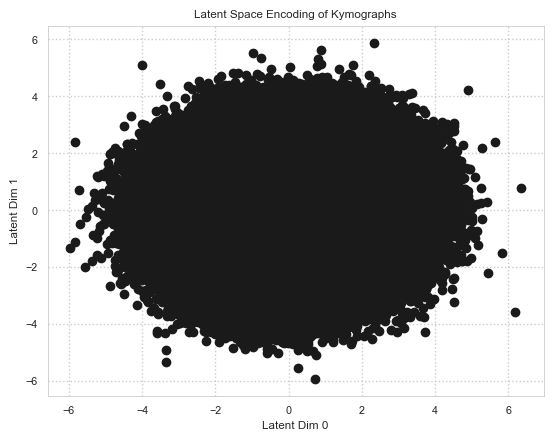

In [14]:
exp_dataset = ExpKymoDataset()
plot_latent(VAE, dataset, dims=[0,1], exp_data=None)

# Current model needs more normalization, still large gaps in latent space...
# Implement PCA to compress latent_dims for visualization?
# Also should implement batching if possible, right now we iterate through entire
# dataset in the same order, probably leading to wonky reconstructions below as model overfits

We can see that the VAE is not doing a very good job at producing meaningful recondstructions however...
This is potentially because it is compressing into at pretty low dimensional latent space, giving it control only over total and relative brightness and some other unclear parameters, hence why all the reconstructed kymos look like scaled copies of one another despite separation in the latent space.

89
141
239


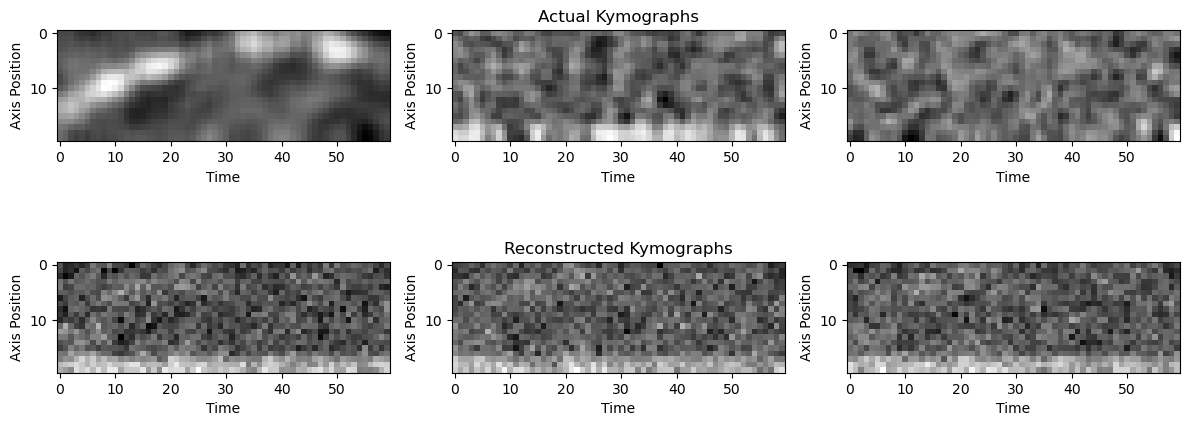

In [9]:
# Sample reconstructed kymographs
plot_sample_im(VAE, dataset)

## Save and load models

In [10]:
# Set save_model = True and run cell to save model state
save_model = False
model_name = 'VAE_2.25.24.pt'

if save_model:
    torch.save(VAE.state_dict(), models_folder+model_name)

In [11]:
# Set load_model = True and run cell to save model state
load_model = False
model_name = 'VAE_2.25.24.pt'
if load_model:
    model = Autoencoder(latent_dims=2).to(device)
    model.load_state_dict(torch.load(models_folder+model_name))
    model.eval()

## Jamie's Plotting

(300, 48000)
300
torch.Size([1, 20, 60])


IndexError: index 3 is out of bounds for axis 0 with size 3

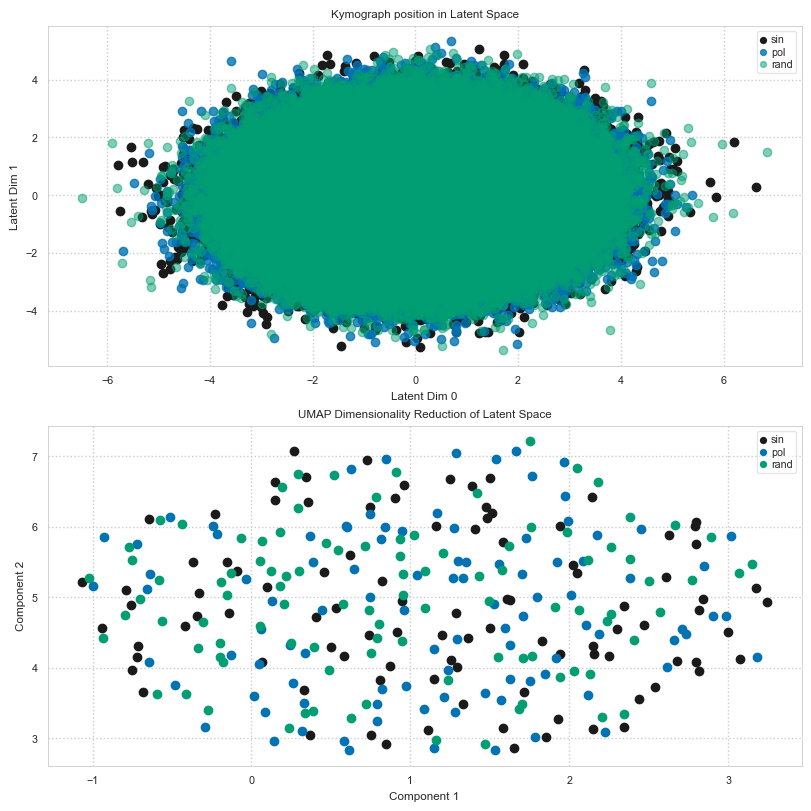

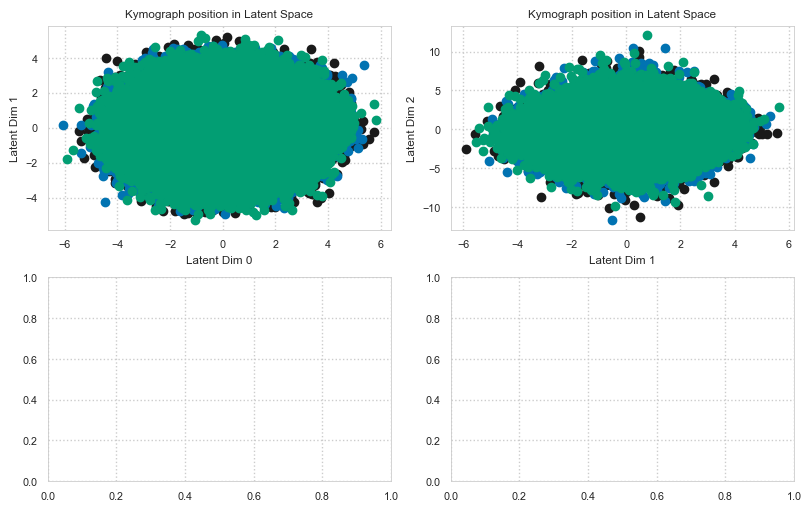

In [12]:
import seaborn as sns
from string import ascii_lowercase
import matplotlib
from matplotlib import gridspec, pyplot as plt

matplotlib.rcParams["legend.labelspacing"] = 0.2
matplotlib.rcParams["legend.fontsize"] = 8
matplotlib.rcParams["xtick.major.pad"] = 1.0
matplotlib.rcParams["ytick.major.pad"] = 1.0
matplotlib.rcParams["xtick.minor.pad"] = 0.9
matplotlib.rcParams["ytick.minor.pad"] = 0.9
matplotlib.rcParams["legend.handletextpad"] = 0.5
matplotlib.rcParams["legend.handlelength"] = 0.5
matplotlib.rcParams["legend.framealpha"] = 0.5
matplotlib.rcParams["legend.markerscale"] = 0.7
matplotlib.rcParams["legend.borderpad"] = 0.35

def getSetup(figsize, gridd, multz=None, empts=None):
    """ Establish figure set-up with subplots. """
    sns.set(style="whitegrid", font_scale=0.7, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

    # create empty list if empts isn't specified
    if empts is None:
        empts = []

    if multz is None:
        multz = dict()

    # Setup plotting space and grid
    f = plt.figure(figsize=figsize, constrained_layout=True)
    gs1 = gridspec.GridSpec(*gridd, figure=f)

    # Get list of axis objects
    x = 0
    ax = list()
    while x < gridd[0] * gridd[1]:
        if x not in empts and x not in multz.keys():  # If this is just a normal subplot
            ax.append(f.add_subplot(gs1[x]))
        elif x in multz.keys():  # If this is a subplot that spans grid elements
            ax.append(f.add_subplot(gs1[x: x + multz[x] + 1]))
            x += multz[x]
        x += 1

    return (ax, f)


def subplotLabel(axs):
    """ Place subplot labels on figure. """
    for ii, ax in enumerate(axs):
        ax.text(-0.2, 1.2, ascii_lowercase[ii], transform=ax.transAxes, fontsize=16, fontweight="bold", va="top")


def plot_latent_w_reduction(ax1, ax2, autoencoder, data, trans_data, dims=[0,1], exp_data=None):
            
    assert len(dims) == 2
    assert data.__len__() == trans_data.shape[0]
    
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        if i < 99:
            ax1.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            ax1.scatter(z[dims[0]], z[dims[1]], c='b', label = ('pol' if i == 101 else None), alpha = 0.8)
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='b', label = ('pol' if i == 101 else None))
        else:
            ax1.scatter(z[dims[0]], z[dims[1]], c='g', label = ('rand' if i == 201 else None), alpha = 0.5)
            ax2.scatter(trans_data[i, 0], trans_data[i, 1], c='g', label = ('rand' if i == 201 else None))


    if exp_data != None:
        for i, z in enumerate(exp_data):
            z.reshape(1,20,60)
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            ax1.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None), alpha = 0.3)

    ax1.set_xlabel('Latent Dim {}'.format(dims[0]))
    ax1.set_ylabel('Latent Dim {}'.format(dims[1]))
    ax1.legend()
    ax1.set_title('Kymograph position in Latent Space')

    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.legend()
    ax2.set_title('UMAP Dimensionality Reduction of Latent Space')


from umap import UMAP

#latent_dims = 100 #as used above in original VAE

X = np.zeros(((dataset.__len__(), 48000)))

print(X.shape)
print(dataset.__len__())
print(dataset.__getitem__(3).shape)

for i, x in enumerate(dataset):
    z = VAE.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    X[i] = np.ravel(z)

reducer = UMAP(n_components=2)
X_trans = reducer.fit_transform(X)

ax, f = getSetup((8, 8), (2, 1))

plot_latent_w_reduction(ax[0], ax[1], VAE, dataset, X_trans) 
     

import seaborn as sns
from string import ascii_lowercase
import matplotlib
#import svgutils.transform as st
from matplotlib import gridspec, pyplot as plt


matplotlib.rcParams["legend.labelspacing"] = 0.2
matplotlib.rcParams["legend.fontsize"] = 8
matplotlib.rcParams["xtick.major.pad"] = 1.0
matplotlib.rcParams["ytick.major.pad"] = 1.0
matplotlib.rcParams["xtick.minor.pad"] = 0.9
matplotlib.rcParams["ytick.minor.pad"] = 0.9
matplotlib.rcParams["legend.handletextpad"] = 0.5
matplotlib.rcParams["legend.handlelength"] = 0.5
matplotlib.rcParams["legend.framealpha"] = 0.5
matplotlib.rcParams["legend.markerscale"] = 0.7
matplotlib.rcParams["legend.borderpad"] = 0.35


def getSetup(figsize, gridd, multz=None, empts=None):
    """ Establish figure set-up with subplots. """
    sns.set(style="whitegrid", font_scale=0.7, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

    # create empty list if empts isn't specified
    if empts is None:
        empts = []

    if multz is None:
        multz = dict()

    # Setup plotting space and grid
    f = plt.figure(figsize=figsize, constrained_layout=True)
    gs1 = gridspec.GridSpec(*gridd, figure=f)

    # Get list of axis objects
    x = 0
    ax = list()
    while x < gridd[0] * gridd[1]:
        if x not in empts and x not in multz.keys():  # If this is just a normal subplot
            ax.append(f.add_subplot(gs1[x]))
        elif x in multz.keys():  # If this is a subplot that spans grid elements
            ax.append(f.add_subplot(gs1[x: x + multz[x] + 1]))
            x += multz[x]
        x += 1

    return (ax, f)


def subplotLabel(axs):
    """ Place subplot labels on figure. """
    for ii, ax in enumerate(axs):
        ax.text(-0.2, 1.2, ascii_lowercase[ii], transform=ax.transAxes, fontsize=16, fontweight="bold", va="top")
     

def new_plot_latent(axis, autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            axis.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            axis.scatter(z[dims[0]], z[dims[1]], c='b', label = ('pol' if i == 101 else None))
        else:
            axis.scatter(z[dims[0]], z[dims[1]], c='g', label = ('rand' if i == 201 else None))

    if exp_data != None:
        for i, x in enumerate(exp_data):
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            axis.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None))

    axis.set_xlabel('Latent Dim {}'.format(dims[0]))
    axis.set_ylabel('Latent Dim {}'.format(dims[1]))
    axis.set_title('Kymograph position in Latent Space')
    axis.legend
     

ax, f = getSetup((8, 5), (2, 2))

for i, ax in enumerate(ax):
    new_plot_latent(ax, VAE, dataset, dims=[i,i+1])
     

ax, f = getSetup((8, 5), (2, 2))

for i, ax in enumerate(ax):
    new_plot_latent(ax, VAE, dataset, dims=[i,i+2])
     